# 📍 문자 단위 RNN(Char RNN)

- 모든 시점의 입력에 대해서 모든 시점에 대해서 출력을 하는 다대다 RNN
- 다대다 RNN은 대표적으로 품사 태깅, 개체명 인식 등에서 사용
- RNN의 입출력의 단위가 단어 레벨(word-level)이 아니라 문자 레벨(character-level)로 하여 RNN을 구현한다면, 이를 문자 단위 RNN이라고 합니다

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## ✅ 1. 훈련 데이터 전처리하기

- 문자 시퀀스 apple을 입력받으면 delicious를 출력하는 RNN을 구현할 예정입니다!
- 입력 데이터와 레이블 데이터에 대해서 문자 집합(voabulary)을 만듭니다(문자 집합은 중복을 제거한 문자들의 집합)

In [ ]:
input_str = 'apple'
label_str = 'pple!'
char_vocab = sorted(list(set(input_str+label_str)))
vocab_size = len(char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 5


📢 현재 문자 집합에는 총 5개의 문자가 있습니다. !, a, e, l, p .이제 하이퍼파라미터를 정의해줍니다. 이때 입력은 원-핫 벡터를 사용할 것이므로 입력의 크기는 문자 집합의 크기여야만 합니다.

In [ ]:
input_size = vocab_size # 입력의 크기는 문자 집합의 크기
hidden_size = 5
output_size = 5
learning_rate = 0.1

📢 이제 문자 집합에 고유한 정수를 부여합니다.

In [ ]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab)) # 문자에 고유한 정수 인덱스 부여
print(char_to_index)

{'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}


📢 나중에 예측 결과를 다시 문자 시퀀스로 보기위해서 반대로 정수로부터 문자를 얻을 수 있는 index_to_char을 만듭니다.

In [ ]:
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key
print(index_to_char)

{0: '!', 1: 'a', 2: 'e', 3: 'l', 4: 'p'}


📢 이제 입력 데이터와 레이블 데이터의 각 문자들을 정수로 맵핑합니다.

In [ ]:
x_data = [char_to_index[c] for c in input_str]
y_data = [char_to_index[c] for c in label_str]
print(x_data)
print(y_data)

[1, 4, 4, 3, 2]
[4, 4, 3, 2, 0]


**📢 파이토치의 nn.RNN()은 기본적으로 3차원 텐서를 입력받습니다. 그렇기 때문에 배치 차원을 추가해줍니다.**

In [ ]:
# 배치 차원 추가
x_data_ = [x_data]
y_data_ = [y_data]
print(x_data_)
print(y_data_)

[[1, 4, 4, 3, 2]]
[[4, 4, 3, 2, 0]]


In [ ]:
# 텐서 연산인 unsqueeze(0)를 통해 해결할 수도 있습니다.
x_data_2 = torch.tensor(x_data).unsqueeze(0)
y_data_2 = torch.tensor(y_data).unsqueeze(0)
print(x_data_2)
print(y_data_2)

tensor([[1, 4, 4, 3, 2]])
tensor([[4, 4, 3, 2, 0]])


📢 입력 시퀀스의 각 문자들을 원-핫 벡터로 바꿔줍니다.

In [ ]:
x_one_hot = [np.eye(vocab_size)[x] for x in x_data_]
print(x_one_hot)

[array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])]


📢 입력 데이터와 레이블 데이터를 텐서로 바꿔줍니다.

In [ ]:
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data_)

<ipython-input-11-26da95e14f28>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.FloatTensor(x_one_hot)


In [ ]:
# 각 텐서 크기 확인
print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

훈련 데이터의 크기 : torch.Size([1, 5, 5])
레이블의 크기 : torch.Size([1, 5])


## ✅ 모델 구현하기


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True) # RNN 셀 구현
        self.fc = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현

    def forward(self, x): # 구현한 RNN 셀과 출력층을 연결
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [ ]:
net = Net(input_size, hidden_size, output_size)

In [ ]:
outputs = net(X)
print(outputs.shape) # 3차원 텐서

torch.Size([1, 5, 5])


📢 (1, 5, 5)의 크기를 가지는데 각각 배치 차원, 시점(timesteps), 출력의 크기입니다. 나중에 정확도를 측정할 때는 이를 모두 펼쳐서 계산하게 되는데, 이때는 view를 사용하여 배치 차원과 시점 차원을 하나로 만듭니다.

In [ ]:
print(outputs.view(-1, input_size).shape) # 2차원 텐서로 변환

torch.Size([5, 5])


**📢 레이블 데이터 크기 RECAP**

In [ ]:
print(Y.shape)
print(Y.view(-1).shape)

torch.Size([1, 5])
torch.Size([5])


📢 레이블 데이터는 (1, 5)의 크기를 가지는데, 마찬가지로 나중에 정확도를 측정할 때는 이걸 펼쳐서 계산할 예정입니다. 이 경우 (5)의 크기를 가지게 됩니다. 이제 옵티마이저와 손실 함수를 정의합니다.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [ ]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, input_size), Y.view(-1)) # view를 하는 이유는 Batch 차원 제거를 위해
    loss.backward() # 기울기 계산
    optimizer.step() # 아까 optimizer 선언 시 넣어둔 파라미터 업데이트

    # 아래 세 줄은 모델이 실제 어떻게 예측했는지를 확인하기 위한 코드.
    result = outputs.data.numpy().argmax(axis=2) # 최종 예측값인 각 time-step 별 5차원 벡터에 대해서 가장 높은 값의 인덱스를 선택
    result_str = ''.join([index_to_char[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)


0 loss:  1.5940128564834595 prediction:  [[4 4 4 4 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  ppppp
1 loss:  1.3612526655197144 prediction:  [[4 4 4 3 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  ppplp
2 loss:  1.1792747974395752 prediction:  [[4 4 3 3 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  ppllp
3 loss:  0.9960570335388184 prediction:  [[4 4 3 3 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  ppllp
4 loss:  0.7894635796546936 prediction:  [[4 4 3 2 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  pplep
5 loss:  0.6030434370040894 prediction:  [[4 4 3 2 4]] true Y:  [4, 4, 3, 2, 0] prediction str:  pplep
6 loss:  0.45468267798423767 prediction:  [[4 4 3 2 0]] true Y:  [4, 4, 3, 2, 0] prediction str:  pple!
7 loss:  0.3351694643497467 prediction:  [[4 4 3 2 0]] true Y:  [4, 4, 3, 2, 0] prediction str:  pple!
8 loss:  0.23538097739219666 prediction:  [[4 4 3 2 0]] true Y:  [4, 4, 3, 2, 0] prediction str:  pple!
9 loss:  0.16626331210136414 prediction:  [[4 4 3 2 0]] true Y:  [4, 4,

## ✅ 실습 과제

**📢 <font color=red> 'Network'가 주어졌을 때 'Amazing'이 출력되도록 CharRNN을 학습시켜 보자**

# 📍 문자 단위 RNN - with sentence data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

## ✅ 1. 훈련 데이터 전처리하기

In [ ]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [ ]:
print(len(sentence))

180


In [ ]:
char_set = list(set(sentence)) # 중복을 제거한 문자 집합 생성
char_dic = {c: i for i, c in enumerate(char_set)} # 각 문자에 정수 인코딩

In [ ]:
print(char_dic) # 공백도 여기서는 하나의 원소

{'n': 0, ' ': 1, 't': 2, 's': 3, 'r': 4, 'm': 5, 'g': 6, 'l': 7, 'b': 8, 'h': 9, 'e': 10, ',': 11, 'i': 12, 'c': 13, 'y': 14, 'f': 15, "'": 16, 'd': 17, 'p': 18, 'a': 19, 'u': 20, 'o': 21, 'w': 22, 'k': 23, '.': 24}


📢 각 문자에 정수가 부여되었으며, 총 25개의 문자가 존재! 문자 집합의 크기 또한 25

In [ ]:
dic_size = len(char_dic)
print('문자 집합의 크기 : {}'.format(dic_size))

문자 집합의 크기 : 25


📢 입력을 원-핫 벡터로 사용할 것이므로 이는 매 시점마다 들어갈 입력의 크기이기도 합니다. hidden_size(은닉 상태의 크기)를 입력의 크기와 동일하게 줬는데, 이는 사용자의 선택으로 다른 값을 줘도 무방!

In [ ]:
# 우리가 앞서 만든 샘플을 10개 단위로 끊어서 샘플을 만들 예정
# sequence_length라는 변수 활용
hidden_size = dic_size
sequence_length = 10  # 임의 숫자 지정
learning_rate = 0.1

📢 sequence_length 값인 10의 단위로 샘플들을 잘라서 데이터를 만들기

In [ ]:
# 데이터 구성
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

📢 총 170개의 샘플이 생성되었습니다. 그리고 각 샘플의 각 문자들은 고유한 정수로 인코딩이 된 상태입니다.

In [ ]:
print(x_data[0])
print(y_data[0])

[12, 15, 1, 14, 21, 20, 1, 22, 19, 0]
[15, 1, 14, 21, 20, 1, 22, 19, 0, 2]


📢 한 칸씩 쉬프트 된 시퀀스가 정상적으로 출력되는 것을 볼 수 있습니다. 이제 입력 시퀀스에 대해서 원-핫 인코딩을 수행하고, 입력 데이터와 레이블 데이터를 텐서로 변환합니다.

In [ ]:
x_one_hot = [np.eye(dic_size)[x] for x in x_data] # x 데이터는 원-핫 인코딩
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [ ]:
print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

훈련 데이터의 크기 : torch.Size([170, 10, 25])
레이블의 크기 : torch.Size([170, 10])


In [ ]:
print(X[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
print(Y[0])

tensor([15,  1, 14, 21, 20,  1, 22, 19,  0,  2])


## ✅ 모델 구현하기

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layers): # 현재 hidden_size는 dic_size와 같음.
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [ ]:
net = Net(dic_size, hidden_size, 2) # 이번에는 층을 두 개 쌓습니다. -> Deep RNN

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [ ]:
print(outputs.view(-1, dic_size).shape) # 2차원 텐서로 변환.

torch.Size([1700, 25])


In [ ]:
print(Y.shape)
print(Y.view(-1).shape)

torch.Size([170, 10])
torch.Size([1700])


📢 학습을 진행해봅시다!

In [ ]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X) # (170, 10, 25) 크기를 가진 텐서를 매 에포크마다 모델의 입력으로 사용
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    # results의 텐서 크기는 (170, 10)
    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        if j == 0: # 처음에는 예측 결과를 전부 가져오지만
            predict_str += ''.join([char_set[t] for t in result])
        else: # 그 다음에는 마지막 글자만 반복 추가
            predict_str += char_set[result[-1]]

    print(predict_str)

hhhhhhhhohhhdhbhhhhhbhhhohhhbhhhhdhhhdhhdobdhhoohbhhbhbhhhhhhhhobbhhhbhohhbhhhhdhhhdhhhoobhbdhhhhhhhoobhhhhhohhabhhhhhodhhhhhhhhabhhhhhdhhhhhohhohhdhhhhhhhhhobhhhhhhobhhhhhhhhhhoh
oo o o o o oo  o       oo    o   o   o  o  o  oo  o    o   o  o o     o        o   o  o o   o    o o o     o  o  o     o    o  o  oo   o  o o  o   o   o  o oo o    oo    o oo  o  
 eee eee  tt e e   e ete et  e e   e e dee ee ee  ee  ee  tee  eee  e e ee eee e ete e d eet ee  eette etd eee   e  tee e e e ete ee   ee    e  eet e tee e e t e   ee e   e e  eee
omb.o m..sdds dds d d dd sd to ds   ddsdsdsd   sdd dddd  dd ddd  snd dd d dds dddd dt sdsd d d  t  ddst sd s  tot  ddd sdds  ddddt sddds td   dd dd d ddsddddtdd   ddt ddd d  sdsdd
ttttottttsttottntse tnta tn tottt ttttntnktttntottnttttttttottt  ttottttt ttt tatttototttott kt    to stdotnta atotttttontetotttottttnttttotsttttttotitntttt  totttots ntttto ttntt
t     to tot  totto t tt t l   t  t  t t tto    tto     t    to   t     to ttoto tttt t t     t    t

In [ ]:
print(predict_str)

m uou want to build a ship, don't drum up people together to bollect wood and don't dssign them tosks and work, but rather teach them to long for the endless immensity of the sea 


**📢 <font color=red>실습 문제 - 어떤 문자열이라도 sample에 들어가면 동작할 수 있도록 설계된 Charseq 코드를 구현해보자**

In [ ]:
sample = " if you want you"

# make dictionary
char_set = list(set(sample))
char_dic = {c: i for i, c in enumerate(char_set)}
print(char_dic)

# hyper parameters
dic_size = len(char_dic)
hidden_size = len(char_dic)
learning_rate = 0.1

# data setting
sample_idx = [char_dic[c] for c in sample]
x_data = [sample_idx[:-1]]
x_one_hot = [np.eye(dic_size)[x] for x in x_data]
y_data = [sample_idx[1:]]

# transform as torch tensor variable
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

# declare RNN
rnn = torch.nn.RNN(dic_size, hidden_size, batch_first=True)

# loss & optimizer setting
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), learning_rate)

# start training
for i in range(50):
    optimizer.zero_grad()
    outputs, _status = rnn(X)
    loss = criterion(outputs.view(-1, dic_size), Y.view(-1))
    loss.backward()
    optimizer.step()

    result = outputs.data.numpy().argmax(axis=2)
    result_str = ''.join([char_set[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

{'i': 0, 'n': 1, 'a': 2, ' ': 3, 'u': 4, 'o': 5, 'w': 6, 'y': 7, 't': 8, 'f': 9}
0 loss:  2.3076627254486084 prediction:  [[7 5 5 8 2 7 5 8 4 4 4 4 4 5 7]] true Y:  [[0, 9, 3, 7, 5, 4, 3, 6, 2, 1, 8, 3, 7, 5, 4]] prediction str:  yootayotuuuuuoy
1 loss:  2.0335965156555176 prediction:  [[7 5 3 7 5 7 5 7 7 5 7 3 7 5 7]] true Y:  [[0, 9, 3, 7, 5, 4, 3, 6, 2, 1, 8, 3, 7, 5, 4]] prediction str:  yo yoyoyyoy yoy
2 loss:  1.8211897611618042 prediction:  [[7 3 3 7 5 3 3 7 4 3 3 3 7 5 3]] true Y:  [[0, 9, 3, 7, 5, 4, 3, 6, 2, 1, 8, 3, 7, 5, 4]] prediction str:  y  yo  yu   yo 
3 loss:  1.6155986785888672 prediction:  [[7 9 3 7 5 3 3 7 4 3 3 3 7 5 3]] true Y:  [[0, 9, 3, 7, 5, 4, 3, 6, 2, 1, 8, 3, 7, 5, 4]] prediction str:  yf yo  yu   yo 
4 loss:  1.4512320756912231 prediction:  [[7 9 3 7 5 4 3 7 2 1 8 3 7 5 4]] true Y:  [[0, 9, 3, 7, 5, 4, 3, 6, 2, 1, 8, 3, 7, 5, 4]] prediction str:  yf you yant you
5 loss:  1.3311790227890015 prediction:  [[7 9 3 7 5 4 3 7 2 1 8 3 7 5 4]] true Y:  [[0, 9, 3,

# 📍 문자-단위 RNN으로 이름 분류하기

데이터 주소: https://download.pytorch.org/tutorial/data.zip

In [ ]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive')

Mounted at /content/drive


📢 data/names 디렉토리에는 [Language].txt 라는 18 개의 텍스트 파일이 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어 있습니다. (그러나, 유니코드에서 ASCII로 변환해야 함).

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('/content/drive/My Drive/AIoT/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/My Drive/AIoT/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/My Drive/AIoT/data/names/Scottish.txt', '/content/drive/My Drive/AIoT/data/names/Korean.txt', '/content/drive/My Drive/AIoT/data/names/Greek.txt', '/content/drive/My Drive/AIoT/data/names/Portuguese.txt', '/content/drive/My Drive/AIoT/data/names/Spanish.txt', '/content/drive/My Drive/AIoT/data/names/Italian.txt', '/content/drive/My Drive/AIoT/data/names/Dutch.txt', '/content/drive/My Drive/AIoT/data/names/German.txt', '/content/drive/My Drive/AIoT/data/names/Japanese.txt', '/content/drive/My Drive/AIoT/data/names/Chinese.txt', '/content/drive/My Drive/AIoT/data/names/Vietnamese.txt', '/content/drive/My Drive/AIoT/data/names/French.txt', '/content/drive/My Drive/AIoT/data/names/Czech.txt', '/content/drive/My Drive/AIoT/data/names/Arabic.txt', '/content/drive/My Drive/AIoT/data/names/Polish.txt', '/content/drive/My Drive/AIoT/data/names/English.txt', '/content/drive/My Drive/AIoT/data/names/Irish.txt', '/content/drive/My Drive/AIoT/data/names/Russian.txt']
Slusarski


In [ ]:
print(category_lines)

{'Scottish': ['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart', 'Thomson', 'Robertson', 'Anderson', 'Macdonald', 'Scott', 'Reid', 'Murray', 'Taylor', 'Clark', 'Ross', 'Watson', 'Morrison', 'Paterson', 'Young', 'Mitchell', 'Walker', 'Fraser', 'Miller', 'Mcdonald', 'Gray', 'Henderson', 'Hamilton', 'Johnston', 'Duncan', 'Graham', 'Ferguson', 'Kerr', 'Davidson', 'Bell', 'Cameron', 'Kelly', 'Martin', 'Hunter', 'Allan', 'Mackenzie', 'Grant', 'Simpson', 'Mackay', 'Mclean', 'Macleod', 'Black', 'Russell', 'Marshall', 'Wallace', 'Gibson', 'Kennedy', 'Gordon', 'Burns', 'Sutherland', 'Stevenson', 'Munro', 'Milne', 'Watt', 'Murphy', 'Craig', 'Wood', 'Muir', 'Wright', 'Mckenzie', 'Ritchie', 'Johnstone', 'Sinclair', 'White', 'Mcmillan', 'Williamson', 'Dickson', 'Hughes', 'Cunningham', 'Mckay', 'Bruce', 'Millar', 'Crawford', 'Mcintosh', 'Douglas', 'Docherty', 'King', 'Jones', 'Boyle', 'Fleming', 'Mcgregor', 'Aitken', 'Christie', 'Shaw', 'Maclean', 'Jamieson', 'Mcintyre', 'Hay', 'Lindsay', 'Alexander'

📢 이제 각 category (언어)를 line (이름)에 매핑하는 사전인 category_lines 를 만들었습니다. 나중에 참조할 수 있도록 all_categories (언어 목록)와 n_categories 도 추적합니다.

In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## ✅ 이름을 텐서로 변경

이제 모든 이름 데이터를 로드했으므로, 이를 활용하기 위해 Tensor로 변환해야 합니다.

하나의 문자를 표현하기 위해 크기가 <1 x n_letters> 인 원-핫 벡터를 사용합니다.

단어를 만들기 위해 One-Hot 벡터들을 2차원 행렬 <line_length x 1 x n_letters> 에 결합시킵니다.

위에서 보이는 추가적인 1차원은 배치이겠죠?

In [ ]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## ✅ 네트워크 생성

RNN 모델을 구현해 보겠습니다

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

📢 이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다. 출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를 돌려받습니다.

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

📢 효율성을 위해서 letterToTensor 대신 lineToTensor를 사용하겠습니다.

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9936, -2.9321, -2.9100, -2.9716, -2.7823, -2.7747, -2.9195, -2.8902,
         -2.8426, -2.9563, -2.9636, -3.0449, -2.8332, -2.7805, -2.8483, -2.9151,
         -2.8505, -2.8679]], grad_fn=<LogSoftmaxBackward0>)


## ✅ 학습 준비

- Helper function을 몇 개 선언하자!
- 우리가 알아낸 각 카테고리의 우도(likelihood)인 네트워크 출력을 해석하는 함수

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 위치
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 5)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Solberg
category = Vietnamese / line = Doan
category = Korean / line = Sung
category = Vietnamese / line = Ma
category = French / line = Fontaine
category = Japanese / line = Ando
category = German / line = Jung
category = Scottish / line = Thomson
category = Arabic / line = Hanania
category = Japanese / line = Nanami


## ✅ 모델 학습

- RNN의 마지막 계층이 nn.LogSoftmax 이므로 손실 함수로 nn.NLLLoss 가 적합합니다!!!
- 주의해야할 점은, nn.NLLLoss와 nn.CELoss의 사용법 차이를 잘 알아야합니다.

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 시각화를 위한 loss 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 loss을 전체 loss 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.4500 Sargent / German ✗ (French)
10000 10% (0m 21s) 1.4399 Quach / Vietnamese ✓
15000 15% (0m 31s) 4.3283 Defabr / German ✗ (Russian)
20000 20% (0m 40s) 0.7375 Piccirillo / Italian ✓
25000 25% (0m 48s) 0.1769 Sokolowski / Polish ✓
30000 30% (0m 58s) 0.7308 Maolmhuaidh / Irish ✓
35000 35% (1m 7s) 1.0251 Mondo / Italian ✓
40000 40% (1m 15s) 0.2656 Jankin / Russian ✓
45000 45% (1m 24s) 3.2005 Macon / Irish ✗ (French)
50000 50% (1m 34s) 1.6605 Danas / French ✗ (Greek)
55000 55% (1m 42s) 0.8988 Isa / Arabic ✓
60000 60% (1m 51s) 3.3135 Tosell / Czech ✗ (Spanish)
65000 65% (2m 2s) 0.6994 Paget / French ✓
70000 70% (2m 10s) 0.0538 Matziev / Russian ✓
75000 75% (2m 19s) 0.2902 Gil / Korean ✓
80000 80% (2m 28s) 0.0308 Majewski / Polish ✓
85000 85% (2m 36s) 1.2058 Abascal / Portuguese ✗ (Spanish)
90000 90% (2m 46s) 2.2641 Aarle / Italian ✗ (Dutch)
95000 95% (2m 55s) 0.0047 Brisimitzakis / Greek ✓
100000 100% (3m 3s) 2.2200 Pasternak / Greek ✗ (Polish)


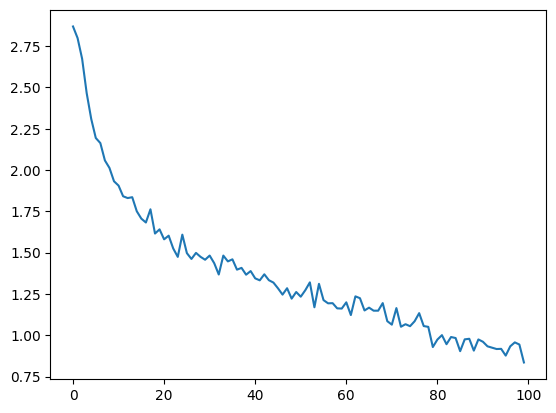

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## ✅ 결과 평가

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해
모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는
혼란 행렬(confusion matrix)을 만듭니다. 혼란 행렬을 계산하기 위해
``evaluate()`` 로 많은 수의 샘플을 네트워크에 실행합니다.
``evaluate()`` 은 ``train ()`` 과 역전파를 빼면 동일합니다.

<ipython-input-159-6bf7967722dc>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-159-6bf7967722dc>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


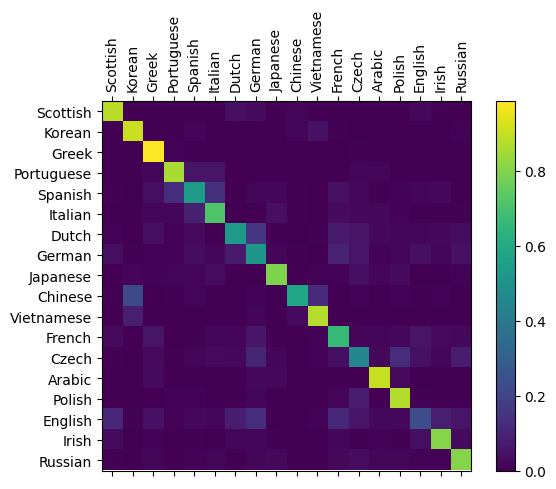

In [ ]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## ✅ 사용자 입력으로 실행

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.36) Russian
(-1.64) Czech
(-2.41) English

> Jackson
(-0.10) Scottish
(-2.80) English
(-4.22) Russian

> Satoshi
(-0.06) Japanese
(-3.45) Arabic
(-3.71) Italian


# 📍 문자-단위 RNN으로 이름 생성하기

- 이름을 읽은 후 그 언어를 예측하는 것과의 큰 차이점은 언어를 입력하고 한 번에 한 글자를 생성하여 출력하는 것입니다. 언어 형성(단어 또는 다른 고차원 구조로도 수행될 수 있음)을 위해 문자를 반복적으로 예측하는 것을 "언어 모델" 이라고 합니다.

- 전의 실습과 데이터 구조가 같습니다. 줄마다 이름이 적힌 텍스트 파일 data/names/[Language].txt 있습니다. 이것을 array로 분리하고, Unicode를 ASCII로 변경하고, 딕셔너리 {language: [names ...]} 을 만들어서 마무리합니다.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path):
  return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/My Drive/AIoT/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Scottish', 'Korean', 'Greek', 'Portuguese', 'Spanish', 'Italian', 'Dutch', 'German', 'Japanese', 'Chinese', 'Vietnamese', 'French', 'Czech', 'Arabic', 'Polish', 'English', 'Irish', 'Russian']
O'Neal


## ✅ 네트워크 생성

- 이 네트워크는 지난 실습에서 활용된 네트워크에 다른 입력들로 연결되는 category tensor를 추가 인자로 가질 수 있어야합니다.
- category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.
- 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에
입력의 사이즈가 n_categories 만큼 커집니다.
- 여기서는 출력을 다음 문자의 확률로 해석합니다. 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.
- 성능 향상을 위해 두 번째 선형 레이어 ``o2o`` (은닉과 출력을 결합한 후) 를 추가하겠습니다.
- Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)으로 만듭니다. -> 과적합 방지

여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기
위해 네트워크의 마지막에 이것을 사용합니다.

<img src='https://drive.google.com/uc?id=1GF_MVvX2gGoCp8mVAX428GXbg7CL-kC5' width=50%>




In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## ✅ 학습 준비

- 마찬가지로, helper function을 하나 생각해봅시다
- 제일 먼저 (category, line)의 무작위 쌍을 얻는 함수

In [ ]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 시점 마다 (즉, 학습 단어의 각 문자 마다) 네트워크의 입력은
``(언어, 현재 문자, 은닉 상태)`` 가 되고, 출력은
``(다음 문자, 다음 은닉 상태)`` 가 됩니다. 따라서 각 학습 세트 마다
언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요하겠죠.

각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에,
문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹입니다. - 예를 들어 ``"ABCD<EOS>"`` 는
("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS") 로 생성합니다.


- Category(언어) Tensor는 ``<1 x n_categories>`` 크기의 원-핫 벡터 입니다.

<img src='https://drive.google.com/uc?id=1WOaZwvzDio6B1v4IoGIeROvuc9ZDZk5F' width=100%>


In [ ]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 타겟 값을 위한 두번째 문자 부터 마지막(EOS)까지의 ``LongTensor``
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

📢 학습 동안 편의를 위해 무작위로 (category[언어], line[이름])을 가져오고, 필요한 형태 (category[언어], input[현재 문자], target[다음 문자]) Tensor로 바꾸는
``randomTrainingExample`` 함수를 만들겠습니다!

In [ ]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## ✅ 네트워크 학습

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # 또는 그냥 ``loss = 0`` 을 사용해도 됩니다.

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

📢 학습에 걸리는 시간을 추적하기 위해 사람이 읽을 수 있는 문자열을
반환하는``timeSince (timestamp)`` 함수를 추가합니다:


In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 21s (5000 5%) 2.5242
0m 39s (10000 10%) 2.4598
0m 58s (15000 15%) 2.7219
1m 19s (20000 20%) 2.7751
1m 37s (25000 25%) 2.3474
1m 54s (30000 30%) 2.6281
2m 12s (35000 35%) 2.7748
2m 30s (40000 40%) 2.5055
2m 47s (45000 45%) 1.7364
3m 6s (50000 50%) 3.7637
3m 25s (55000 55%) 1.7590
3m 46s (60000 60%) 2.1872
4m 6s (65000 65%) 2.1982
4m 25s (70000 70%) 1.8614
4m 43s (75000 75%) 2.3172
5m 1s (80000 80%) 2.5115
5m 18s (85000 85%) 2.5041
5m 40s (90000 90%) 2.0285
5m 59s (95000 95%) 2.6463
6m 16s (100000 100%) 2.2527


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## ✅ 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고
이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

-  입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하고,
-  시작 문자로 ``output_name`` 문자열을 생성한 후에
-  최대 출력 길이까지,

   -  현재 문자를 네트워크에 전달합니다.
   -  가장 높은 output 값으로부터 다음 문자와 다음 은닉 상태를 얻습니다.
   -  만일 문자가 EOS면, STOP
   -  만일 일반적인 문자라면, ``output_name`` 에 추가하고 과정 반복.

-  마지막에 이름을 반환하면 결과를 얻습니다!

In [ ]:
max_length = 20

# 카테고리와 시작 문자로부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovali
Uarin
Sharin
Ganger
Ering
Ramer
Salla
Para
Allan
Chin
Han
Iua


# 📍 장단기 메모리(Long Short-Term Memory, LSTM)

- 앞서 배운 RNN을 가장 단순한 형태의 RNN이라고 하여 바닐라 RNN(Vanilla RNN)이라고 합니다
- 바닐라 RNN은 출력 결과가 이전의 계산 결과에 의존하고, 비교적 짧은 시퀀스(sequence)에 대해서만 효과를 보이는 단점이 존재
- 시점(time step)이 길어질 수록 앞의 정보가 뒤로 충분히 전달되지 못하는 현상이 발생!

<img src='https://drive.google.com/uc?id=1mYunOP9R1HdhHSP53UScVVhEC7fQju-N' width=50%>.
- 뒤로 갈수록 $x_1$의 정보량은 손실되고, 시점이 충분히 긴 상황에서는
$x_1$의 전체 정보에 대한 영향력은 거의 의미가 없을 수도 있습니다.
- 워스트 케이스에서는, 가장 중요한 정보가 시점의 앞 쪽에 위치할 수도 있습니다.
- '모스크바에 여행을 왔는데 건물도 예쁘고 먹을 것도 맛있었어. 그런데 글쎄 직장 상사한테 전화가 왔어. 어디냐고 묻더라구 그래서 나는 말했지. 저 여행왔는데요. 여기 ___''
- **장기 의존성 문제(the problem of Long-Term Dependencies)**

## ✅ Vanilla RNN

<img src='https://drive.google.com/uc?id=1fz22N6mTS4lwbUVVSkdmYsec4eVkr7DK' width=50%>

## ✅ LSTM

<img src='https://drive.google.com/uc?id=1GS4uJZcFRQCGNb5NlZdIuwwwthkm5eAM' width=50%>.
- 전통적인 RNN의 이러한 단점을 보완한 RNN의 일종을 장단기 메모리(Long Short-Term Memory)
- LSTM은 은닉층의 메모리 셀에 입력 게이트, 망각 게이트, 출력 게이트를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다.
- 셀 상태(cell state)라는 것이 추가되었음
- $t$ 시점의 셀 상태를 $C_t$로 표현하고 있습니다.
- LSTM은 RNN과 비교하여 긴 시퀀스의 입력을 처리하는데 탁월한 성능을 보입니다.
- 셀 상태 또한 이전에 배운 은닉 상태처럼 이전 시점의 셀 상태가 다음 시점의 셀 상태를 구하기 위한 입력으로서 사용됩니다.  

은닉 상태값과 셀 상태값을 구하기 위해서 새로 추가 된 3개의 게이트를 사용합니다. 각 게이트는 삭제 게이트, 입력 게이트, 출력 게이트라고 부르며 이 3개의 게이트에는 공통적으로 시그모이드 함수가 존재합니다. 시그모이드 함수를 지나면 0과 1사이의 값이 나오게 되는데 이 값들을 가지고 게이트를 조절합니다.

## ✅ (1) 입력 게이트(Input Gate)

<img src='https://drive.google.com/uc?id=1k_WRfQgwIjkgd92HliXM8O248riE0zXN' width=50%>

- $i_t = σ(W_{xi}x_{t} + W_{hi}h_{t-1}+b_i)$
- $g_t = tanh(W_{xg}x_{t} + W_{hg}h_{t-1}+b_g)$
- 입력 게이트는 현재 정보를 기억하기 위한 게이트
- 현재 시점 $t$의 $x$값과 입력 게이트로 이어지는 가중치 $W_{xi}$
를 곱한 값과 이전 시점 $t-1$의 은닉 상태가 입력 게이트로 이어지는 가중치 $W_{hi}$
를 곱한 값을 더하여 시그모이드 함수를 지나고, 이를 $i_t$라고 합니다.
- 현재 시점 $t$의 $x$값과 입력 게이트로 이어지는 가중치 $W_{xi}$를 곱한 값과 이전 시점 $t-1$의 은닉 상태가 입력 게이트로 이어지는 가중치 $W_{hg}$를 곱한 값을 더하여 $tanh$ 함수를 지나고, 이를 $g_t$라고 합니다.
- 시그모이드 함수와 tanh함수를 지나면 각각 0과 1, -1과 1 사이의 값이 두 개가 나오고, 이를 통해 이번에 선택된 기억할 정보의 양을 정합니다

## ✅ (2) 망각 게이트(Forget Gate)

<img src='https://drive.google.com/uc?id=1dY5zFEjLX5QqkCEqGXsEGPGCswLZnmEe' width=50%>

- $f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + b_f)$
- 망각 게이트는 기억을 삭제하기 위한 게이트
- 현재 시점 $t$의 $x$값과 이전 시점 $t-1$의 은닉 상태가 시그모이드 함수를 지납니다
- 시그모이드를 지나면 0과 1 사이의 값이 나오고, 이 값이 망각 과정을 거친 후의 정보의 양을 뜻합니다.
- 0에 가까울수록 망각

## ✅ (3) 셀 상태(Cell state)

<img src='https://drive.google.com/uc?id=12RJ1-qaaEa4v0felSxHHFnUshe1lrv3b' width=50%>

- $C_t = f_t ⊙ C_{t-1} + i_t ⊙ g_t$
- 셀 상태 $C_t$를 LSTM에서는 장기 상태라고도 부름
- 먼저 입력 게이트에서 구한 $i_t, g_t$ 두 값에 원소별 곱 연산을 진행
- 망각 게이트에서 나온 값과 더해줍니다
- 이 값이 현재 시점 $t$의 셀 상태이며, 다음 시점의 셀로 넘어갑니다.

## ✅ (4) 출력 게이트와 은닉 상태(Output Gate)

<img src='https://drive.google.com/uc?id=1E6QqI4agcftbXDsehH5wcgdCphPhOWlT' width=50%>  
- $o_t=\sigma(W_{xo}x_t + W_{ho}h_{t-1} + b_o)$
- $h_t = o_t ⊙ tanh(c_t)$
- 출력 게이트는 현재 시점 $t$의 $x$ 값과 이전 시점의 은닉 상태가 시그모이드 함수를 지난 값입니다.
- 은닉 상태는 셀 상태의 값이 tanh 함수를 지나 나온 -1과 1 사의 값과 출력 게이트의 값을 원소별 곱한 값이 됩니다.

## ✅ 파이토치의 nn.LSTM()

In [ ]:
#nn.LSTM(input_dim, hidden_size, batch_fisrt=True)

NameError: name 'input_dim' is not defined